本页面为`scFAST`与`Stereo-seq`数据分析全纪录
# 1.`scFAST`数据分析
## 1.1 数据读入  
本文矩阵由寻因生物提供，参考基因组为`mm10`

In [1]:
### 构建 MSData 对象 ##

import sys
import os
import stereo as st
from natsort import natsorted

from stereo.core.ms_data import MSData

anno_ms_data = MSData(_relationship='other', _var_type='intersect')
?anno_ms_data.plt.cluster_scatter

Signature: anno_ms_data.plt.cluster_scatter(*args, **kwargs)
Docstring: <no docstring>
File:      ~/miniconda3/envs/rapids-22.12/lib/python3.8/site-packages/stereopy-1.1.0-py3.8.egg/stereo/core/ms_pipeline.py
Type:      function

In [3]:
# 导包并设置全局参数
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import anndata as ad

sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
os.chdir('/home/biomamba/analysis/scfast_Stereo/')
sc.settings.set_figure_params(dpi=30, frameon=False, figsize=(10, 10), facecolor='white')

-----
anndata     0.10.3
scanpy      1.9.3
-----
PIL                         9.0.1
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
backcall                    0.2.0
brotli                      NA
certifi                     2023.11.17
cffi                        1.15.0
charset_normalizer          2.0.12
cloudpickle                 2.2.1
colorama                    0.4.4
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2023.4.1
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.6
entrypoints                 0.4
exceptiongroup              1.0.4
e

In [4]:
# 读入时scanpy会自动在内存中创建h5ad
wk =sc.read_10x_mtx(
    './data/scFAST/Whole_kidney/filtered_feature_bc_matrix/',# 包含数据文件的文件夹地址
    var_names='gene_symbols',  # 设置利用基因SYMBOL作为变量名，后续可以作为索引获取对应数据
    cache=True)  
wk

AnnData object with n_obs × n_vars = 7910 × 32285
    var: 'gene_ids', 'feature_types'

In [5]:
# 添加分组注释
wk.obs['Tissue'] = 'Whole Kidney'
wk.obs['Tissue']

AAGCATCTACATTCGAA    Whole Kidney
ATACCGATACCGAGTAC    Whole Kidney
CAAGAGGATGCACGTGG    Whole Kidney
GGTGTTAGCTTGGGTTT    Whole Kidney
GTGTTAGATGACGCAGT    Whole Kidney
                         ...     
GCCAGGTGCTTTGCAGT    Whole Kidney
GATCATGATGTCTTCCC    Whole Kidney
TACCTGCTACTTCTCAA    Whole Kidney
AGTTCGATACCGATAAC    Whole Kidney
CTTACCGGCTCGGCACT    Whole Kidney
Name: Tissue, Length: 7910, dtype: object

In [6]:
# 读入时scanpy会自动在内存中创建h5ad
gm =sc.read_10x_mtx(
    './data/scFAST/Glomerulus/filtered_feature_bc_matrix/',# 包含数据文件的文件夹地址
    var_names='gene_symbols',  # 设置利用基因SYMBOL作为变量名，后续可以作为索引获取对应数据
    cache=True)  
gm

AnnData object with n_obs × n_vars = 6757 × 32285
    var: 'gene_ids', 'feature_types'

In [7]:
# 添加分组注释
gm.obs['Tissue'] = 'Glomerulus'
gm.obs['Tissue']

GGTGGCTATGATTTCCA    Glomerulus
TCCCACACGAATCTCGA    Glomerulus
ACGATCATACCGGACGT    Glomerulus
CGGAACCTACAAGTCAT    Glomerulus
TCGGTCTTACCACACAG    Glomerulus
                        ...    
AGCCAATGCTATCCTTT    Glomerulus
CGTAGTACGAGGCTGCT    Glomerulus
GAGCCTGGCTGGTTACT    Glomerulus
TGGATCAATGAACTCTT    Glomerulus
TCTTTGATACGTTCTCG    Glomerulus
Name: Tissue, Length: 6757, dtype: object

In [8]:
wk.obs.shape

(7910, 1)

In [9]:
gm.obs.shape

(6757, 1)

In [10]:
# 两对象合并
import anndata as ad

# 合并观察者（行）
merged_obs = wk.obs.append(gm.obs)

# 合并变量（列）
merged_var = wk.var.append(gm.var)

# 使用 concat 函数合并两个对象
scRNA = ad.concat([wk, gm], axis = 0, join='outer', index_unique=None)

# 更新合并后的对象的观察者（行）和变量（列）
# scRNA.obs = merged_obs
# scRNA.var = merged_var
scRNA.obs_names_make_unique()
# 检查合并后的对象
print(scRNA)

/tmp/ipykernel_3608887/3510741698.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_obs = wk.obs.append(gm.obs)
/tmp/ipykernel_3608887/3510741698.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_var = wk.var.append(gm.var)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 14667 × 32285
    obs: 'Tissue'


In [22]:
scRNA.obs['Tissue'].unique()

array(['Whole Kidney', 'Glomerulus'], dtype=object)

In [12]:
scRNA.obs.shape

(14667, 1)

## 1.2 预处理  
### 1.2.1 质控过滤

In [32]:
os.makedirs('./output/01.procession')

/home/biomamba/miniconda3/envs/st13/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


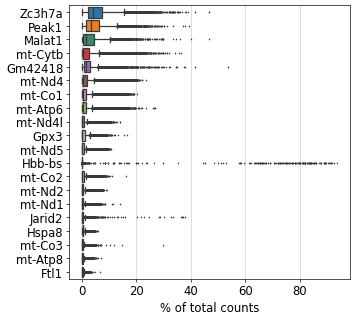

In [13]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt


# 创建一个PdfPages对象，指定保存的文件名
pdf_pages = PdfPages('./output/01.procession/top20_variable_genes.pdf')

# 计算并以箱线图的形式展示表达量最高的二十个基因
fig, ax = plt.subplots(figsize=(6, 6))  # 设置图形的大小
sc.pl.highest_expr_genes(scRNA, n_top=20, ax=ax)  # 传递 ax 参数以确保图形添加到指定的坐标轴
# 将图形添加到PdfPages
pdf_pages.savefig(fig)
plt.close(fig)

# 关闭PdfPages对象，保存PDF文件
pdf_pages.close()

In [14]:
# 过滤掉表达基因数量不足两百的细胞：
sc.pp.filter_cells(scRNA, min_genes=200)

# 过滤掉表达细胞数量不足3个的基因：
sc.pp.filter_genes(scRNA, min_cells=3)

In [15]:
# 由于死细胞胞浆中RNA丢失等因素，死细胞的线粒体mRNA(mt-mRNA)的含量通常较高
# 我们需要进行计算并设置合理的阈值进行过滤。
# 注释mt-mRNA为"mt":
scRNA.var['mt'] = scRNA.var_names.str.startswith('mt-') # 此处为人类，固用^MT，小鼠需要换为^mt
# 计算mt-mRNA含量:
sc.pp.calculate_qc_metrics(scRNA, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'Tissue' as categorical


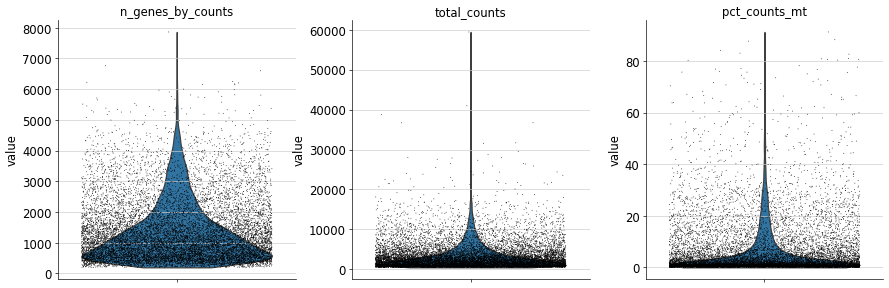

In [16]:
# 可视化n_genes_by_counts、total_counts、pct_counts_mt等质控指标
sc.pl.violin(scRNA, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

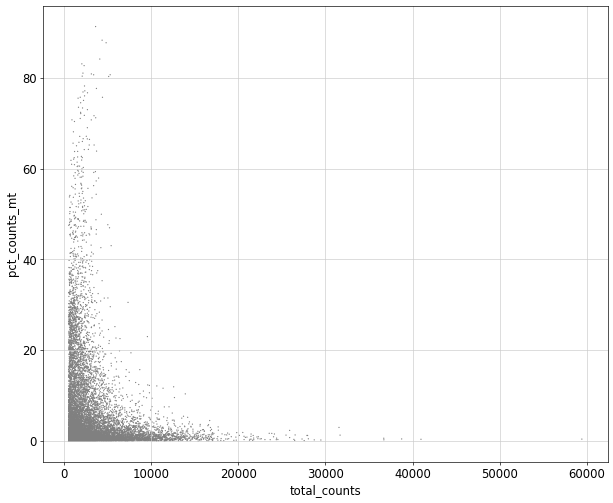

In [17]:
# 展现线粒体count与细胞总count的相关性：
sc.pl.scatter(scRNA, x='total_counts', y='pct_counts_mt')

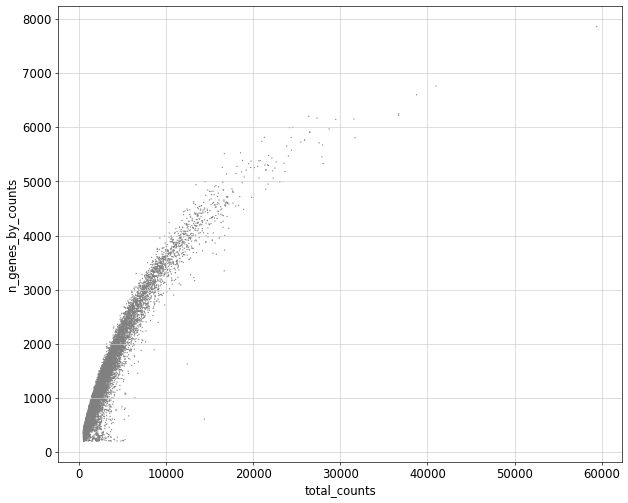

In [18]:
# 展现细胞基因数量与细胞总count间的相关性
sc.pl.scatter(scRNA, x='total_counts', y='n_genes_by_counts')

In [19]:
# 保留每个细胞中表达基因少于6000的细胞
scRNA = scRNA[scRNA.obs.n_genes_by_counts < 6000, :]
# 保留细胞中mt-mRNA的counts比例小于5%的细胞
scRNA = scRNA[scRNA.obs.pct_counts_mt < 22, :]
scRNA.obs.shape# 还剩11960个细胞

/home/biomamba/miniconda3/envs/st13/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


(11960, 6)

In [20]:
# 标准化数据，将每个细胞的reads数标准化至10,000，
# 这使得相同基因在不同细胞之间的表达量比较成为可能
sc.pp.normalize_total(scRNA, target_sum=1e4)

/home/biomamba/miniconda3/envs/st13/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


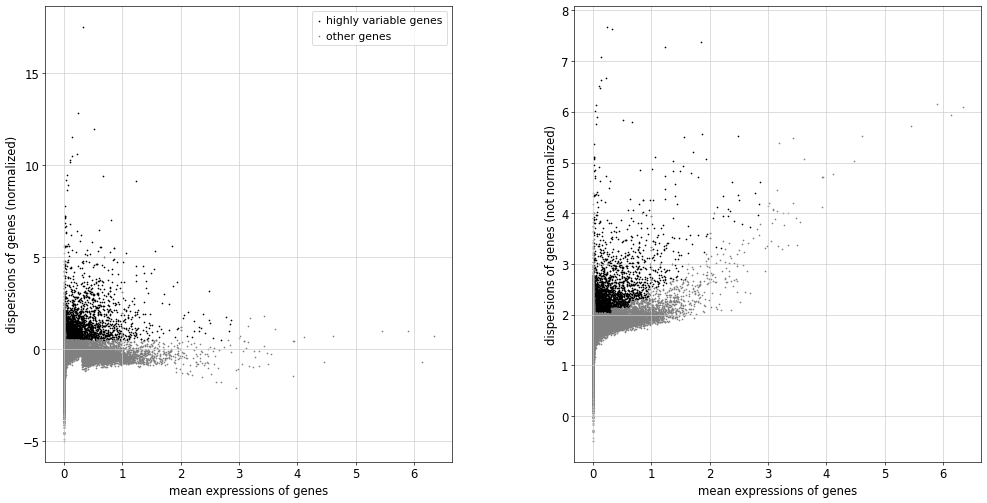

In [21]:
# 对表达矩阵进行log(X+1)的操作
sc.pp.log1p(scRNA)
# 计算高变基因
sc.pp.highly_variable_genes(scRNA, min_mean=0.0125, max_mean=3, min_disp=0.5)
# 可视化基因离散度与平均表达量之间的关系
sc.pl.highly_variable_genes(scRNA)

In [22]:
# 利用view操作对AnnData做一个备份：
scRNA.raw = scRNA
# 这样就能保证你在下游操作失误或想回溯原始数据时具有方便的接口
# 过滤，仅保留高变基因
scRNA = scRNA[:, scRNA.var.highly_variable]

/home/biomamba/miniconda3/envs/st13/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [24]:
# 暂时存储起来
os.makedirs('./output/imagedata')
scRNA.write('./output/imagedata/scRNA_v1.h5ad', compression="gzip")

In [33]:
# 切换为python3内核后重新读入数据
import anndata as ad
scRNA = ad.read('./output/imagedata/scRNA_v1.h5ad')
scRNA.file.close() 
scRNA

/home/biomamba/miniconda3/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 11960 × 2956
    obs: 'Tissue', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

### 1.2.2 降维分群

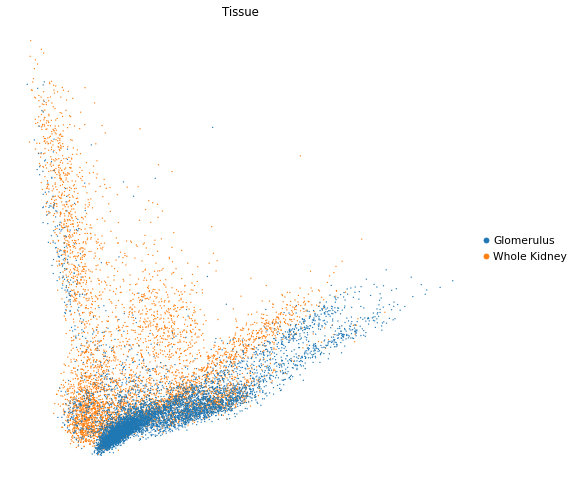

In [34]:
# 回归排除细胞counts总数与线粒体含量对下游分析造成的影响
sc.pp.regress_out(scRNA, ['total_counts', 'pct_counts_mt'])

# 计算每个基因的单位方差，剪辑标准偏差超过10的值，完成“缩放”过程，
# 让每个基因在下游参与降维分群过程中处于“平等”的地位。
sc.pp.scale(scRNA, max_value=10)

# 完成主成分分析(principal component analysis, PCA)
sc.tl.pca(scRNA, svd_solver='arpack')

# 可视化：
sc.pl.pca(scRNA, color='Tissue')

# 虽然可以看出不同Tissue具有一定的差异，但是两者组织不同、基因表达特征不同，PCA自然有差异，所以无需去批次

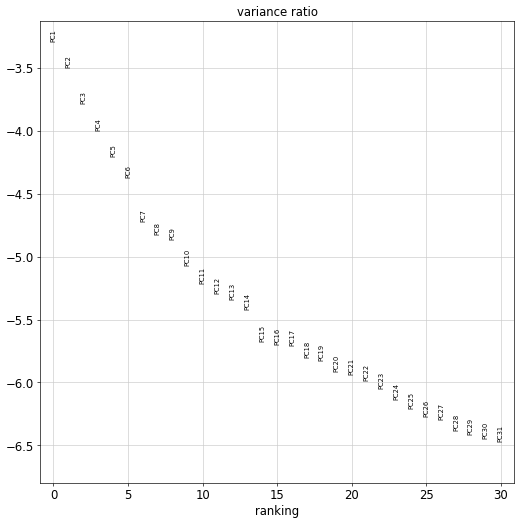

In [35]:
# 计算每个PC对于数据方差的贡献度，决定了下游用于降维、聚类的PC数量：
# 类似于Seurat中的ElbowPlot
sc.pl.pca_variance_ratio(scRNA, log=True)

In [36]:
### 做降维 ###
# 利用PCA代表矩阵计算neighborhood graph，
# n_neighbors可以根据上图中变平缓的转折点选取，一般在10~20之间：
sc.pp.neighbors(scRNA, n_neighbors=20, n_pcs=40)

sc.tl.umap(scRNA)

2023-11-29 05:55:04.687479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/biomamba/miniconda3/pkgs/libglib-2.78.0-hebfc3b9_0/lib:/home/biomamba/miniconda3/envs/pyradiomics/lib
2023-11-29 05:55:04.687558: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


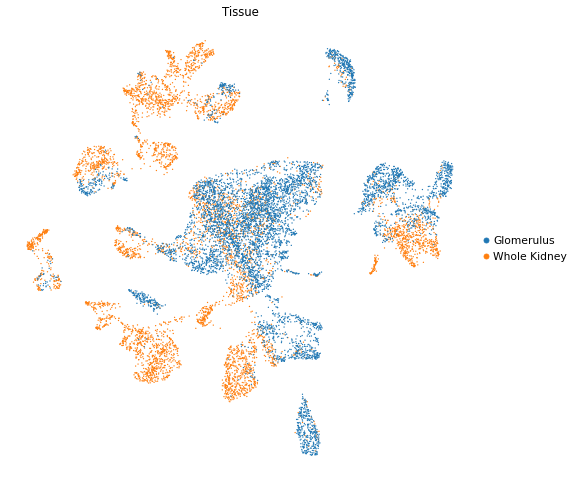

In [37]:
# 查看umap结果
sc.pl.umap(scRNA,color='Tissue')

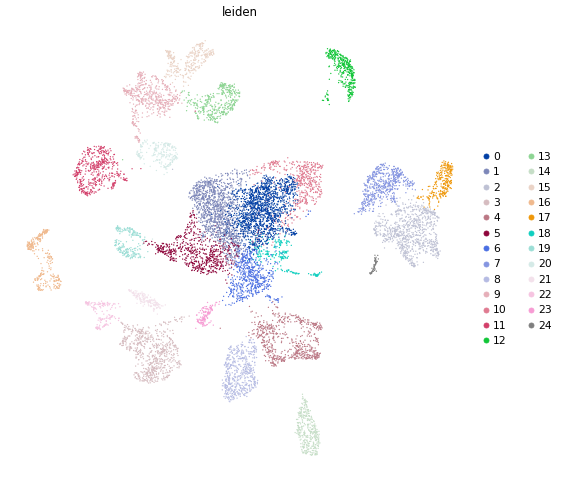

In [38]:
# 分群，这里作者推荐的是Leiden graph-clustering方法：
sc.tl.leiden(scRNA,resolution=0.4)
sc.pl.umap(scRNA, color=['leiden'])

### 1.2.3 细胞注释

ranking genes
    finished (0:00:28)


/home/biomamba/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/biomamba/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/biomamba/miniconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is high

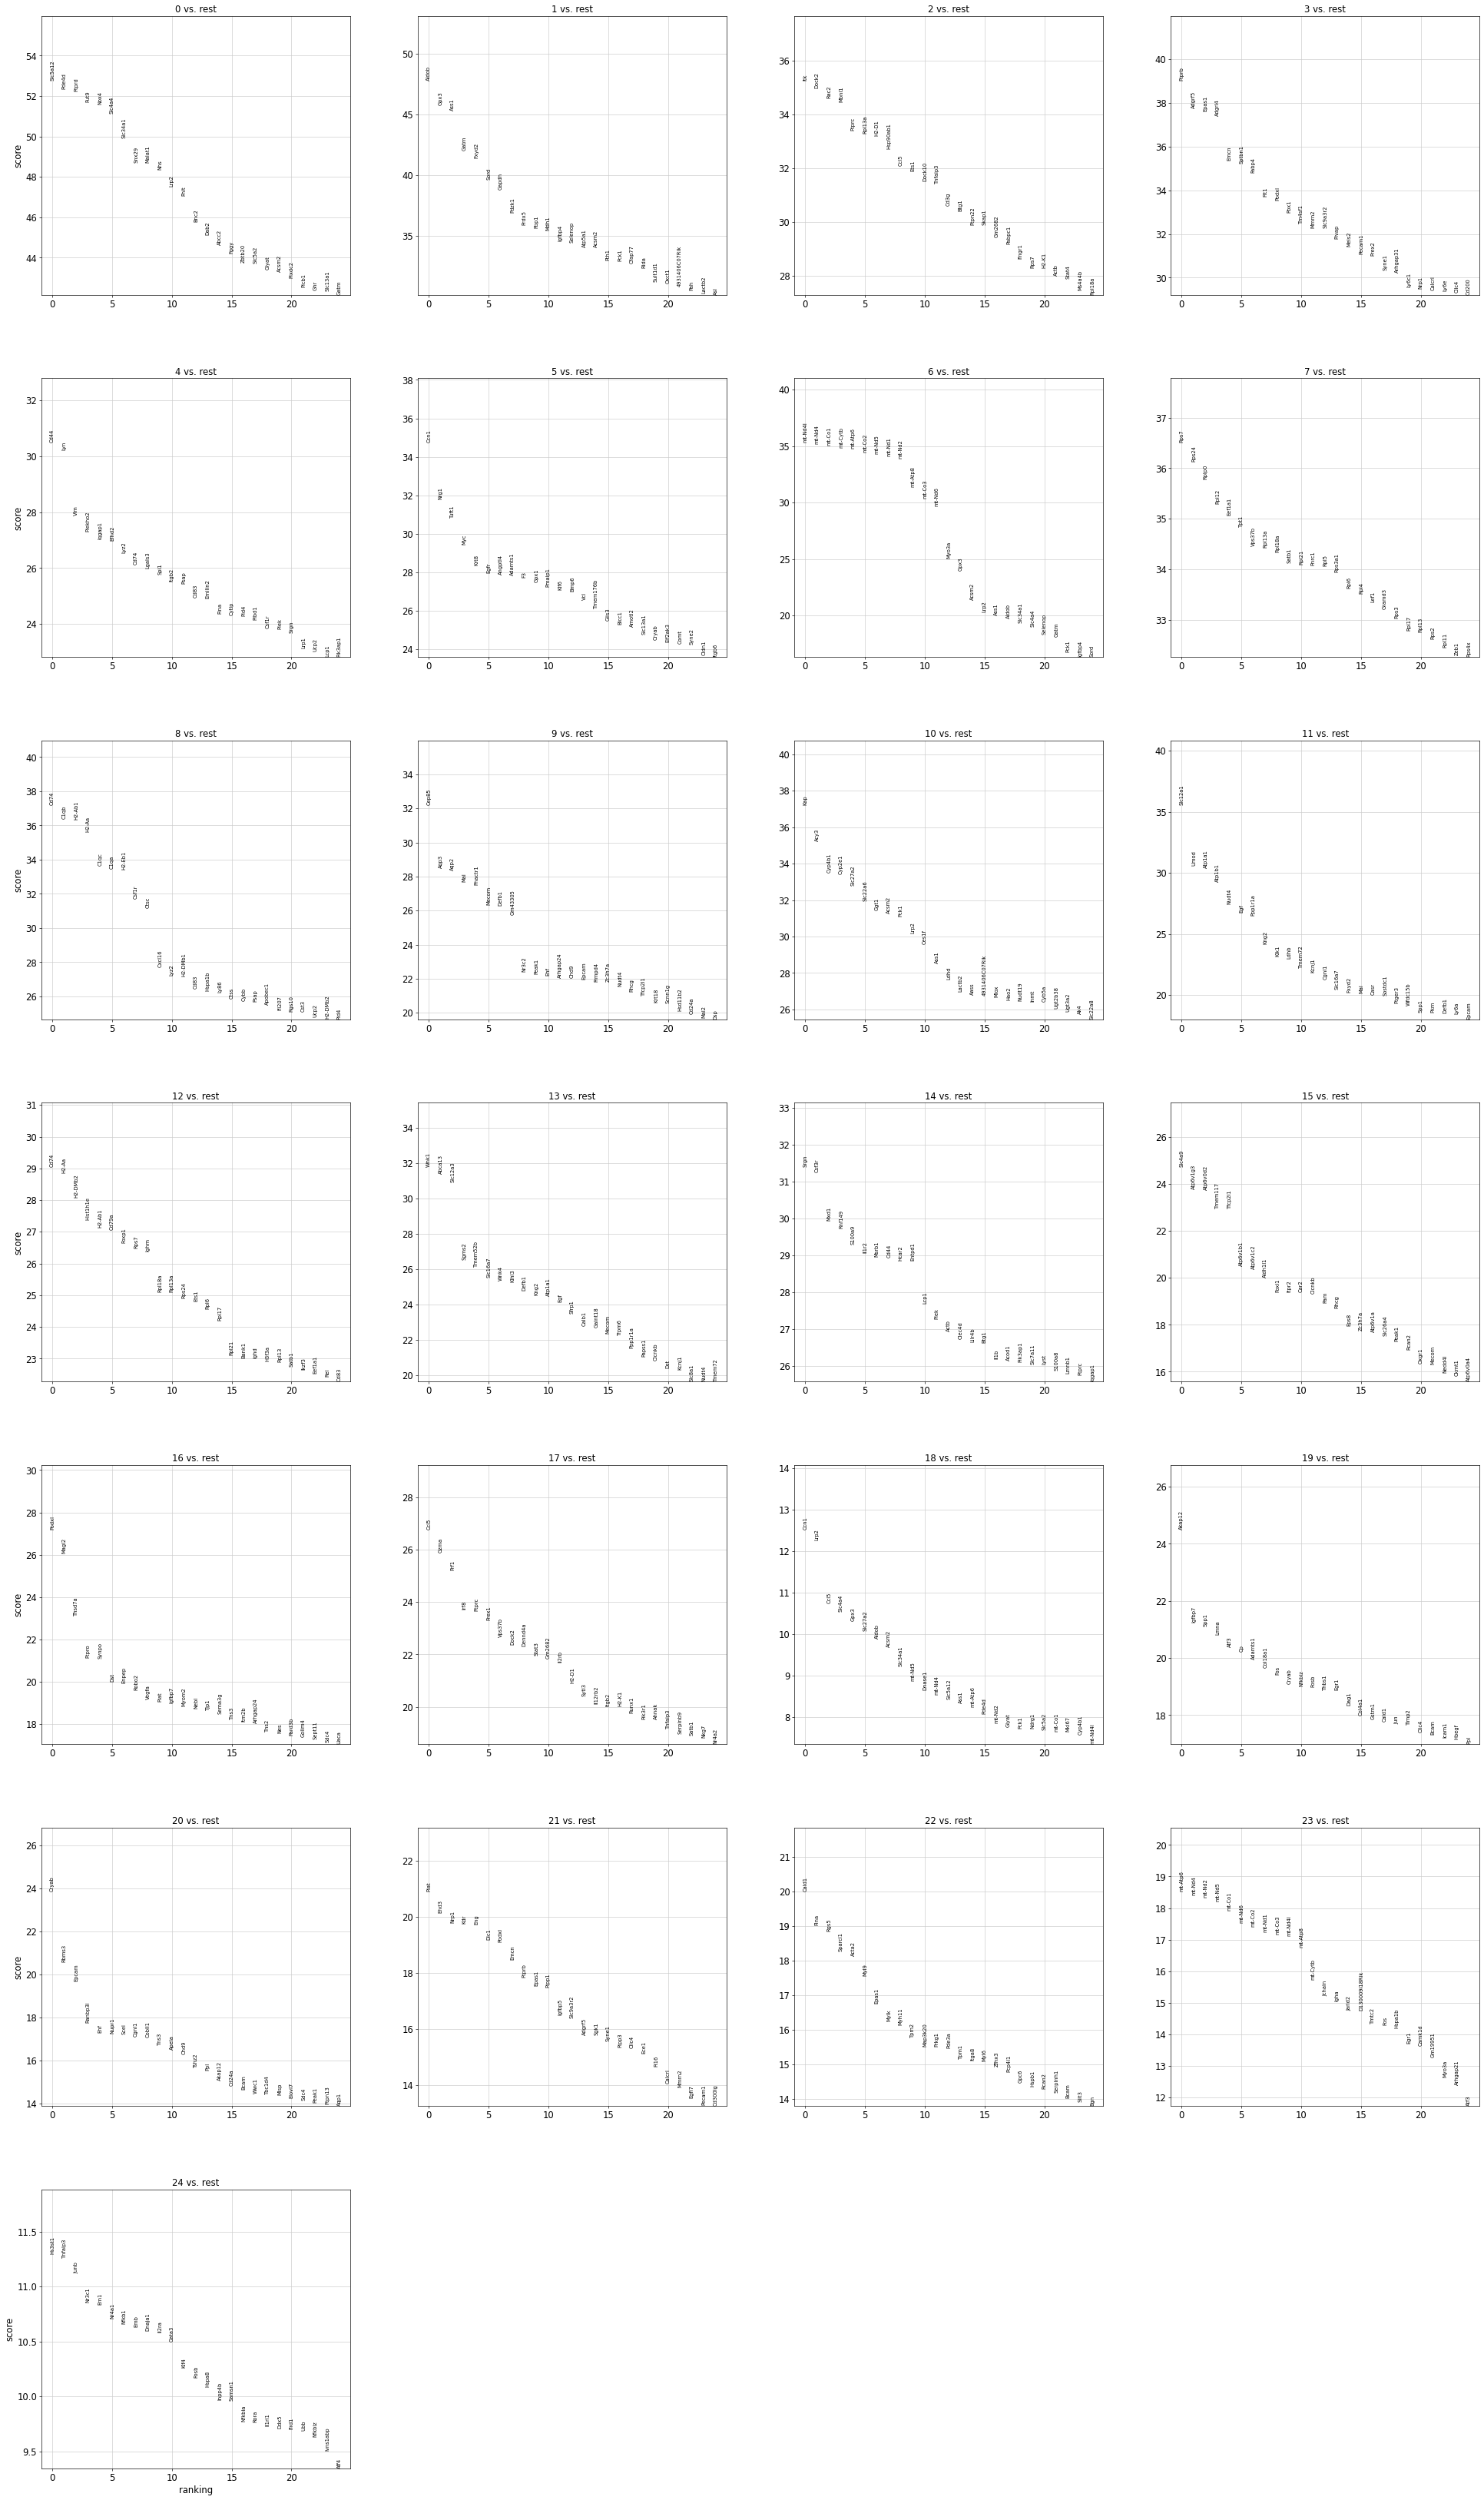

0      1      2       3        4      5        6       7       8  \
0  Slc5a12  Aldob    Itk   Ptprb     Cd44   Ccn1  mt-Nd4l    Rps7    Cd74   
1    Pde4d   Gpx3  Dock2  Adgrf5      Lyn   Nrg1   mt-Nd4   Rps24    C1qb   
2    Ptprd   Ass1   Rac2   Epas1      Vim  Tuft1   mt-Co1   Rplp0  H2-Ab1   
3     Fut9   Gatm  Mbnl1  Adgrl4  Plekho2    Myc  mt-Cytb   Rpl12   H2-Aa   
4     Nox4  Fxyd2  Ptprc    Emcn   Iqgap1   Krt8  mt-Atp6  Eef1a1    C1qc   

         9  ...        15      16     17      18      19       20    21  \
0    Cep85  ...    Slc4a9   Podxl   Ccl5    Ccn1  Akap12    Cryab  Plat   
1     Aqp3  ...  Atp6v1g3   Magi2   Gzma    Lrp2  Igfbp7    Rbms3  Ehd3   
2     Aqp2  ...  Atp6v0d2  Thsd7a   Prf1    Ccl5    Spp1    Epcam  Nrp1   
3      Mal  ...   Tmem117   Ptpro   Irf8  Slc4a4    Lmna  Ranbp3l   Kdr   
4  Phactr1  ...   Tfcp2l1   Synpo  Ptprc    Gpx3    Atf3      Ehf   Eng   

        22       23       24  
0    Cald1  mt-Atp6   Hs3st1  
1     Flna   mt-Nd4  Tnfaip3  
2     Rgs5   mt-Nd2     Junb  
3  Sparcl1   mt-Nd5    Nr3c1  
4    Acta2   mt-Co1     Ern1  

[5 rows x 25 columns]

In [39]:
# 计算marker
# 为marker基因的计算做ranking，最快的是t检验：
# 上面的进度提示过于冗长，设置一下
sc.settings.verbosity = 2  # reduce the verbosity
#  Wilcoxon rank-sum 是作者最推荐的方式，才外还有MAST, limma, DESeq2, diffxpy, logreg等方式 
sc.tl.rank_genes_groups(scRNA, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(scRNA, n_genes=25, sharey=False)

# 这是刚才计算出的每个cluster的top5的marker gene
pd.DataFrame(scRNA.uns['rank_genes_groups']['names']).head(5)

In [40]:
# 查看这些marker在所属cluster中得到的分值：
result = scRNA.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p    1_n  1_p    2_n            2_p     3_n            3_p  \
0  Slc5a12  0.0  Aldob  0.0    Itk  1.350902e-272   Ptprb   0.000000e+00   
1    Pde4d  0.0   Gpx3  0.0  Dock2  4.763355e-268  Adgrf5   0.000000e+00   
2    Ptprd  0.0   Ass1  0.0   Rac2  2.304456e-262   Epas1  7.098524e-310   
3     Fut9  0.0   Gatm  0.0  Mbnl1  1.698418e-260  Adgrl4  5.459001e-306   
4     Nox4  0.0  Fxyd2  0.0  Ptprc  7.013610e-245    Emcn  6.173260e-274   

       4_n            4_p  ...     20_n           20_p  21_n          21_p  \
0     Cd44  3.335679e-204  ...    Cryab  1.204228e-125  Plat  6.684453e-97   
1      Lyn  1.088463e-200  ...    Rbms3   4.813513e-94  Ehd3  4.494536e-90   
2      Vim  3.652418e-171  ...    Epcam   3.103195e-86  Nrp1  4.472524e-87   
3  Plekho2  2.772839e-164  ...  Ranbp3l   1.525648e-70   Kdr  9.015970e-87   
4   Iqgap1  7.494178e-161  ...      Ehf   4.766260e-67   Eng  1.308399e-86   

      22_n          22_p     23_n          23_p     24_n          24_p  
0    Cald1  6.541611e-89  mt-Atp6  1.485777e-76   Hs3st1  1.352320e-29  
1     Flna  1.167815e-80   mt-Nd4  1.229030e-75  Tnfaip3  1.963060e-29  
2     Rgs5  3.059604e-79   mt-Nd2  3.591284e-75     Junb  1.005873e-28  
3  Sparcl1  1.183102e-74   mt-Nd5  4.437742e-74    Nr3c1  1.927058e-27  
4    Acta2  1.818958e-73   mt-Co1  9.582857e-72     Ern1  2.356470e-27  

[5 rows x 50 columns]

In [41]:
result.keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [42]:
# 整理为pd.DataFrame
result_df = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in [ 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

# 将 DataFrame 写入 CSV 文件
result_df.to_csv('./output/01.procession/marker.rank.csv', index=True)  # index=False 表示不保存行索引

In [43]:
# 与Seurat中的不一样，这是一个宽格式的数据
result_df.head()

0_names   0_scores  0_pvals  0_pvals_adj  0_logfoldchanges 1_names  \
0  Slc5a12  52.777363      0.0          0.0          4.497114   Aldob   
1    Pde4d  52.348255      0.0          0.0          3.967919    Gpx3   
2    Ptprd  52.244598      0.0          0.0          4.168376    Ass1   
3     Fut9  51.692600      0.0          0.0          4.266910    Gatm   
4     Nox4  51.592487      0.0          0.0          4.155689   Fxyd2   

    1_scores  1_pvals  1_pvals_adj  1_logfoldchanges  ... 23_names  23_scores  \
0  47.813190      0.0          0.0          4.256553  ...  mt-Atp6  18.517727   
1  45.745762      0.0          0.0          4.241969  ...   mt-Nd4  18.403608   
2  45.298290      0.0          0.0          4.128927  ...   mt-Nd2  18.345423   
3  42.015118      0.0          0.0          3.673097  ...   mt-Nd5  18.208267   
4  41.395927      0.0          0.0          3.313419  ...   mt-Co1  17.911551   

       23_pvals  23_pvals_adj  23_logfoldchanges 24_names  24_scores  \
0  1.485777e-76  3.007212e-72           3.983089   Hs3st1  11.297354   
1  1.229030e-75  1.243778e-71           3.769176  Tnfaip3  11.264571   
2  3.591284e-75  2.422919e-71           4.268254     Junb  11.119720   
3  4.437742e-74  2.245498e-70           4.074947    Nr3c1  10.853132   
4  9.582857e-72  3.879140e-68           3.859977     Ern1  10.834735   

       24_pvals  24_pvals_adj  24_logfoldchanges  
0  1.352320e-29  1.986617e-25           7.936276  
1  1.963060e-29  1.986617e-25           5.199199  
2  1.005873e-28  6.786287e-25           4.402321  
3  1.927058e-27  9.538989e-24           3.904461  
4  2.356470e-27  9.538989e-24           5.049151  

[5 rows x 125 columns]

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


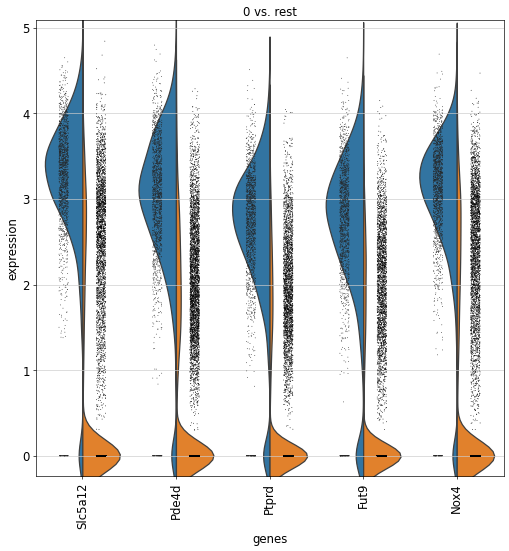

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


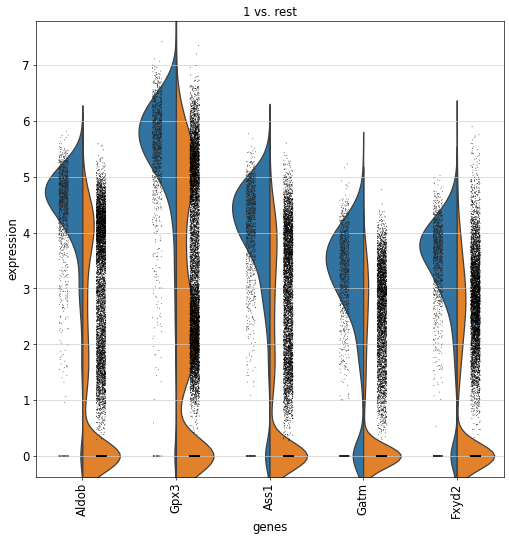

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


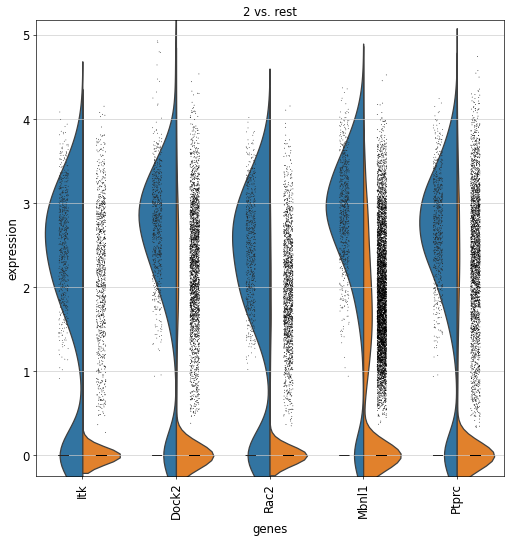

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


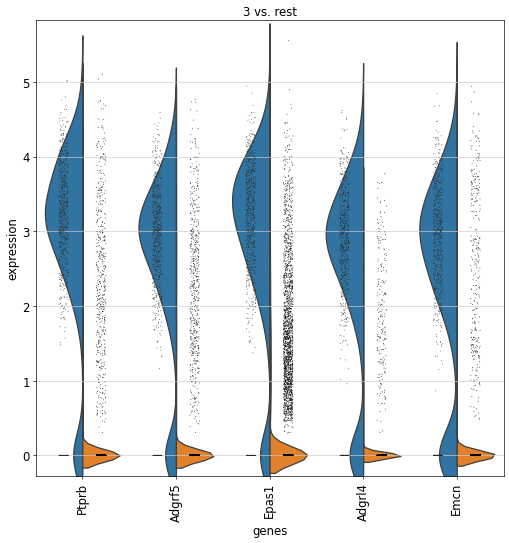

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


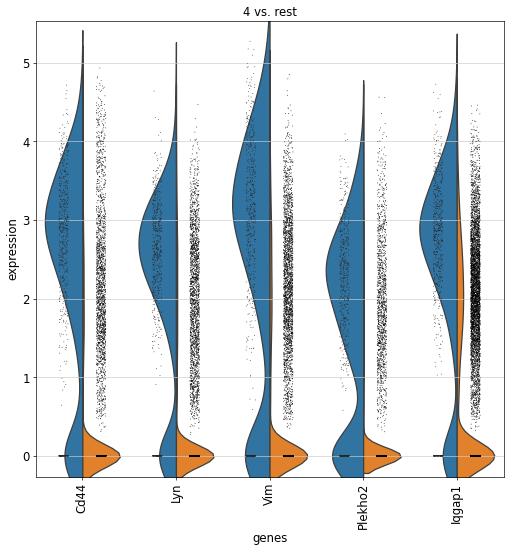

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


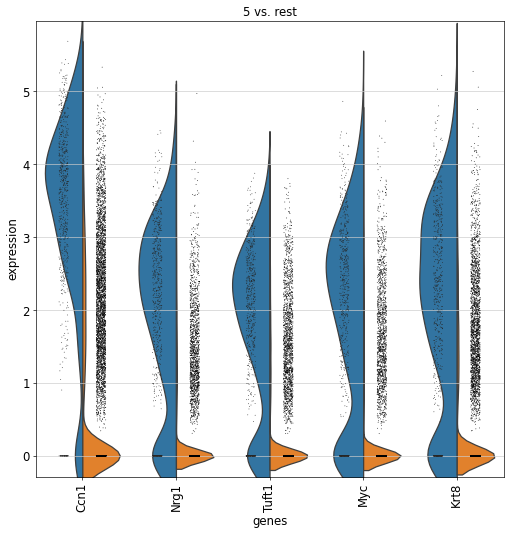

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


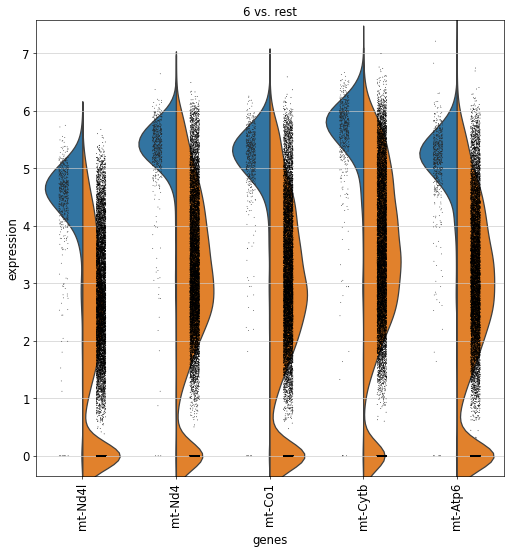

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


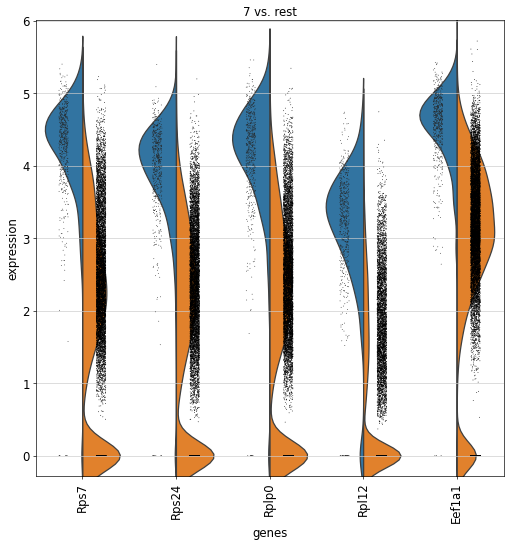

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


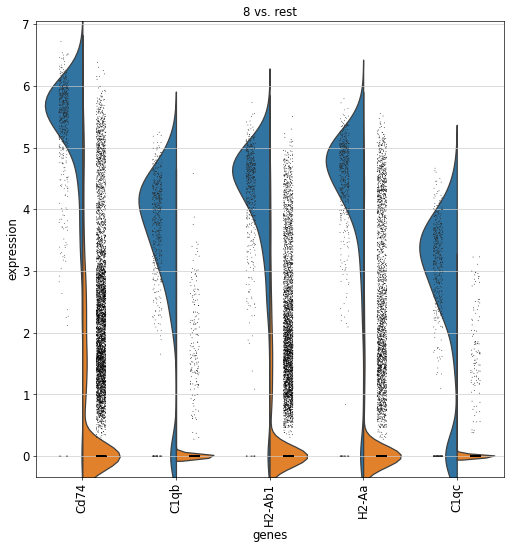

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


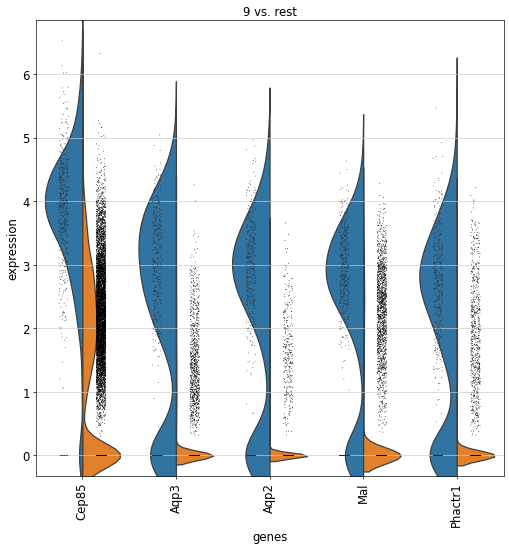

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


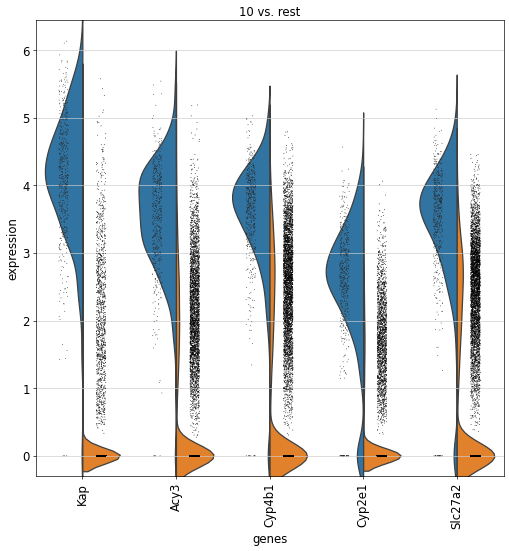

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


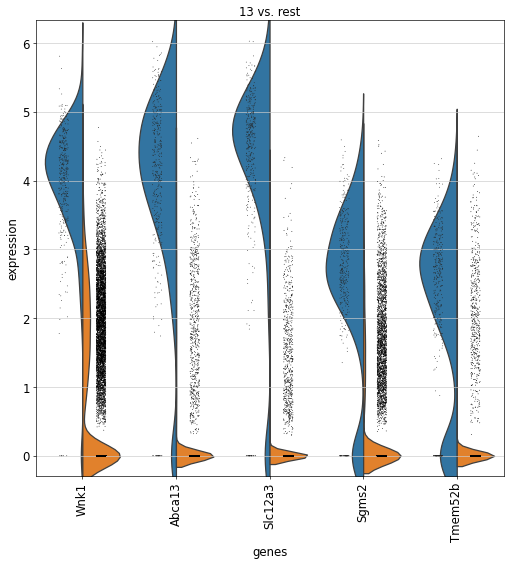

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


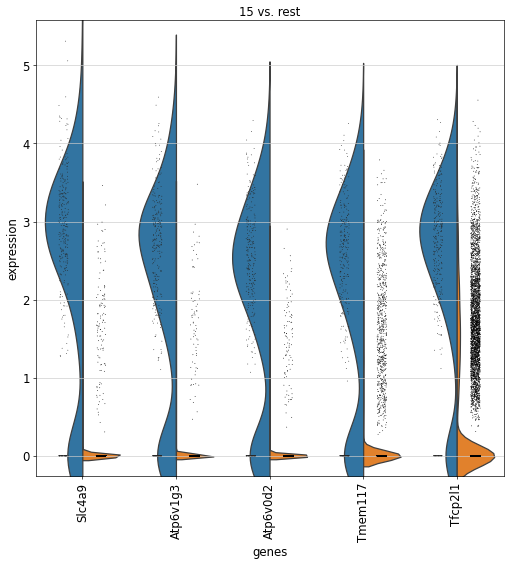

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


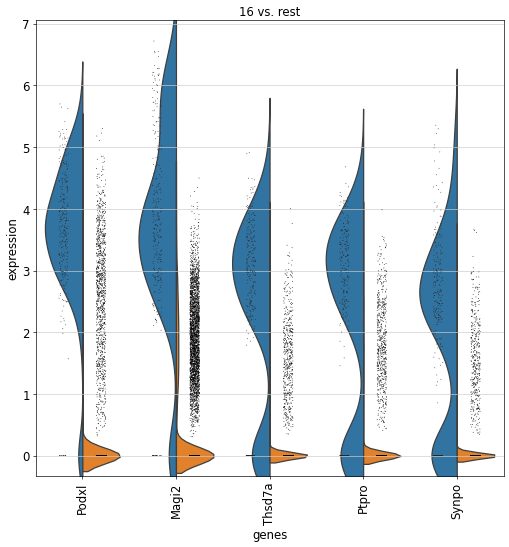

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


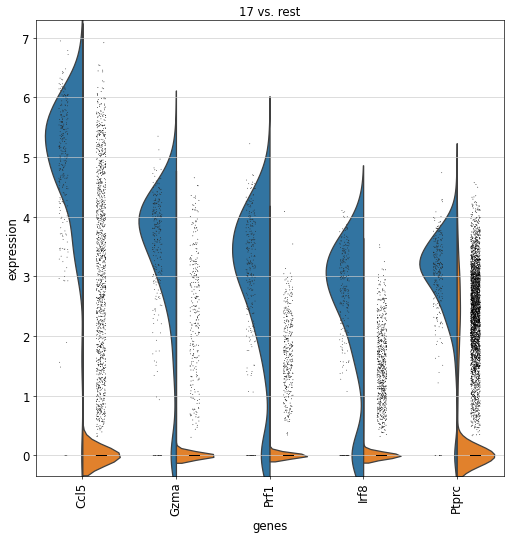

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


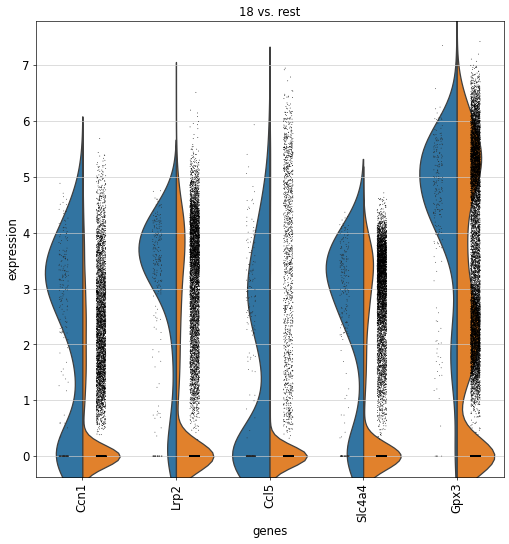

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


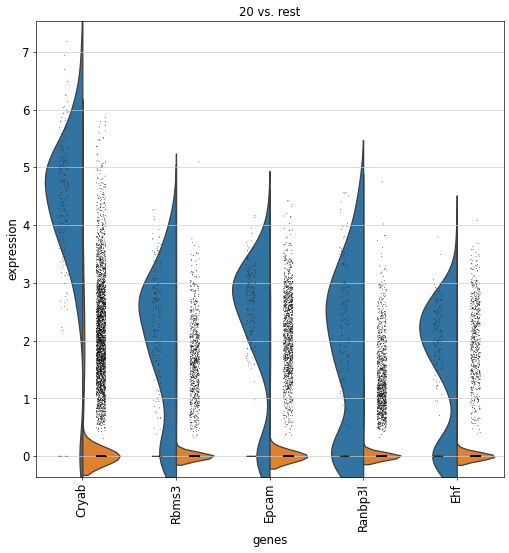

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


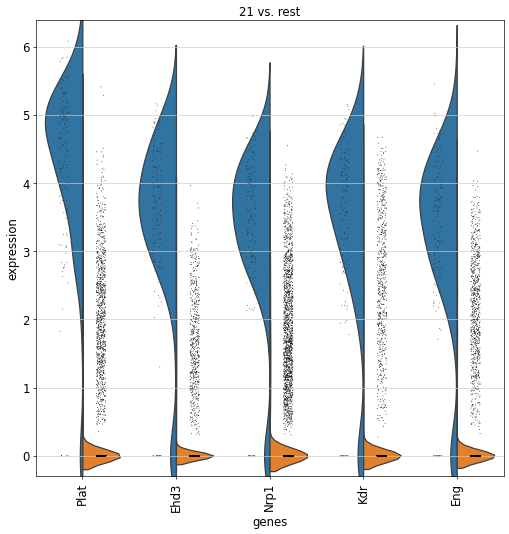

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


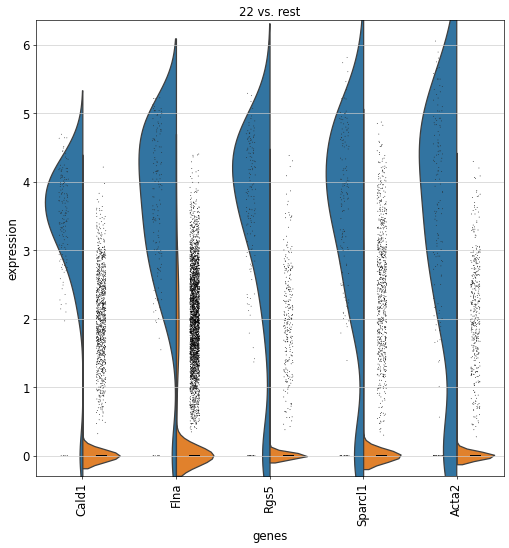

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


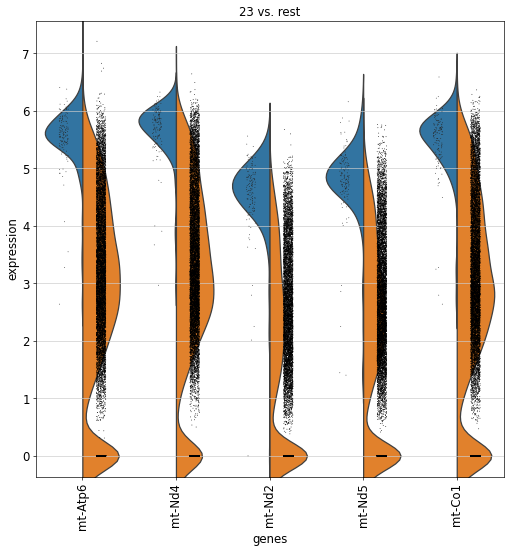

/home/biomamba/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


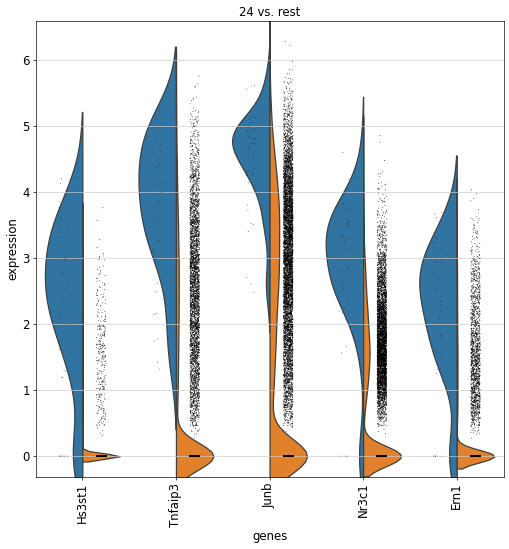

In [37]:
# 看起来大部分的表达量差异都很高，可以用其他可视化方法再进行尝试
sc.pl.rank_genes_groups_violin(scRNA, n_genes=5)#  groups='0',

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


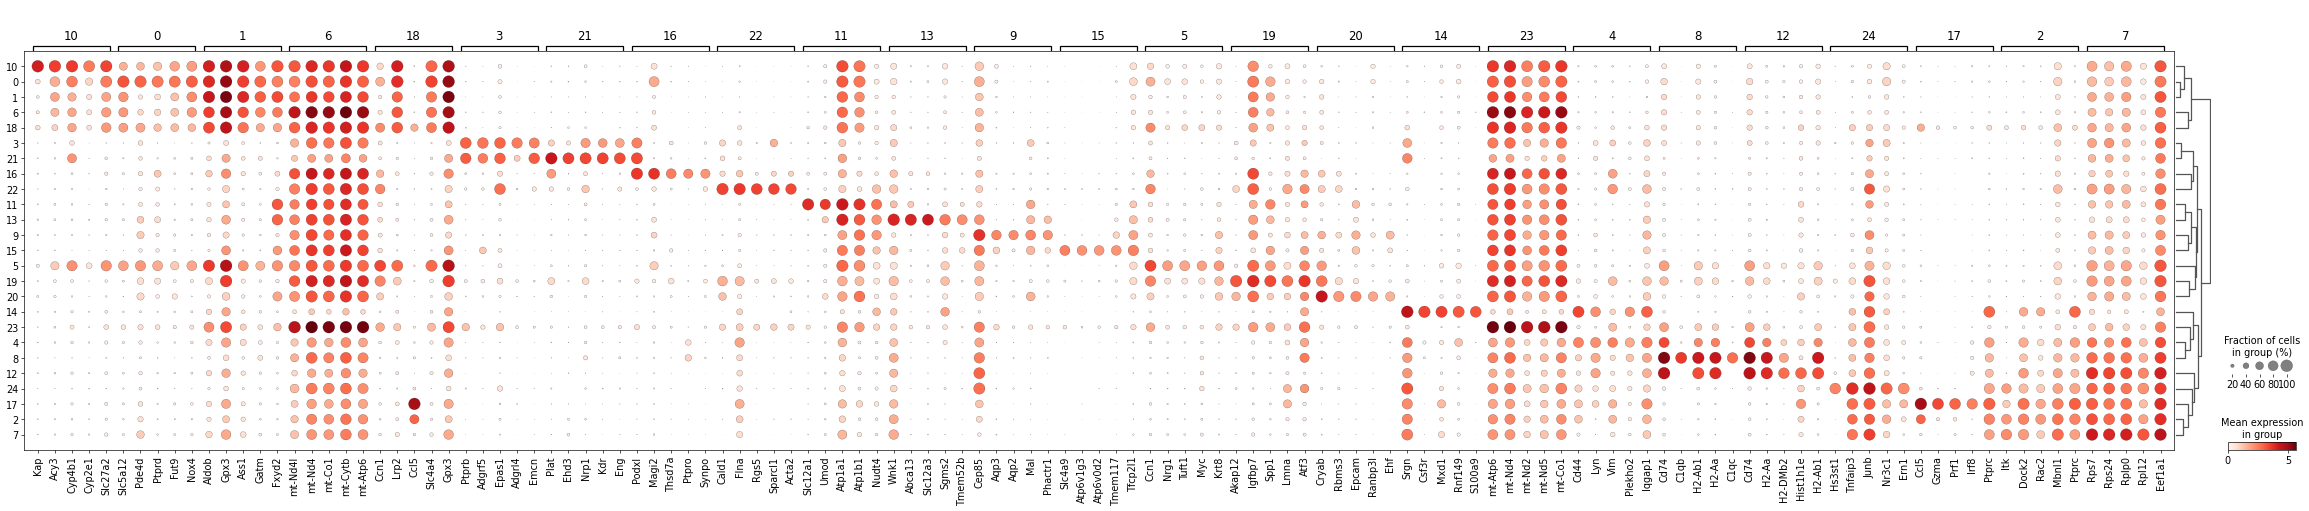

In [44]:
# 画出指定基因在所有cluster中的表达情况：
sc.pl.rank_genes_groups_dotplot(scRNA, n_genes=5)

In [45]:
# 画出指定基因在所有cluster中的表达情况：
sc.pl.rank_genes_groups_stacked_violin(scRNA, n_genes=5,save='round1_marker_dotplot_.pdf')

In [168]:
# 结合umap可以看一下

# Assuming you have a Scanpy object named scRNA
# Replace 'leiden' with your clustering key
sc.pl.umap(scRNA, color='leiden', legend_loc='on data',
           legend_fontsize=20, legend_fontoutline=2,
          save='bf.renamed.pdf')

In [48]:
sc.pl.violin(scRNA,['Ptprc'],groupby='leiden')

- 0：PTC
0、1、6、18、10、23

- 1：
0、1、6、18、10、23

-2 ：T Cell
与7一样，`Ptprc`, `Cd3e`  

- 3: EnC
'Ptprb','Eng','Flt1'

- 4：
待定

- 5：
`Nrg1`、`Tuft1`、`Myc`

- 6: PTC
全是`mt`

- 7:  T Cell  
Ptprc、Cd3e  

- 8：Mac
`C1qb`、`C1qc`

- 9: CD-PC
`Aqp2`

- 10: PTC
`Kap`、`Cyp4b1`

- 11: ALH
`Slc12a1`、`Umod``、`Umod`

- 12：B Cell  
'Cd79a'Neu
- ,'Ig m'

- 13:  DCT
表达'Slc12a3'

- 14：Bst1
计算：Csf3r、 given marker：Retnlg','Chil3,

- 15: CD-IC
Slc4a9, Atp6v1g3, Atp6v0d2, Tmem117

- 16: Podo
Thsd7a, Ptpro, Synpo

- 17：NKC
Gzma、Prf1、Ilf8

- 18: PTC
0、1、6、18、10、23

- 19:  
待定

- 20：DLH
Ranbp3l、Aqp1


- 21：EnC
'Ptprb','Eng','Flt1'

- 22: SMC
`Acta2`

- 23：PTC
全是`mt`

- 24：MC
`Gata3`

In [59]:
# 重命名一下试试
# 重命名各个cluster：
cluster_rename_dict = {
    '0':'PTC',  # 0
    '1':'PTC',  # 1
    '2':'T Cell', # 2
    '3':'EnC',
    '4':'4',
    '5':'PTC', # 5
    '6':'PTC', # 6
    '7':'T Cell', #7
    '8':'Mac', # 8
    '9':'CD-PC', # 9
    '10':'PTC', # 10
    '11':'ALH' ,# 11
    '12':'B Cell', # 12
    '13':'DCT', # 13
    '14':'Neu', # 14
    '15':'CD-IC', # 15
    '16':'Podo', # 16
    '17':'NKC', # 17
    '18':'PTC', # 18,
    '19':'19', # 19
    '20':'DLH' ,#20
    '21':'EnC',
    '22':'SMC',# 参考：https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7609001/
    '23':'PTC', # 23
    '24':'MC'
}

# 使用字典映射进行重命名
scRNA.obs['Celltype'] = scRNA.obs['leiden'].map(cluster_rename_dict)

In [60]:
sc.pl.stacked_violin(scRNA,['Retnlg','Chil3','Mmp8','Gzma','Gzmb','Ncr1','Aqp1','Bst1','Proser2'],groupby='Celltype')

In [61]:
# 保存
scRNA.write('./output/imagedata/scRNA_v3.h5ad', compression="gzip")

In [62]:
# 目前的命名情况：
sc.pl.umap(scRNA, color='Celltype', legend_loc='on data', 
           legend_fontsize=20, legend_fontoutline=2)

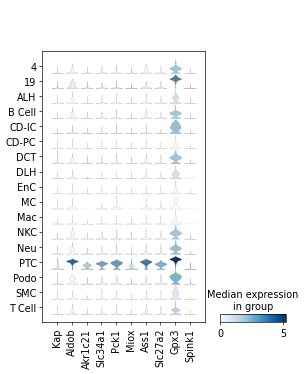

In [63]:
# 基本可以肯定0_1_6_18_10_23_5是近曲小管
sc.pl.stacked_violin(scRNA,["Kap","Aldob","Akr1c21","Slc34a1","Pck1","Miox","Ass1","Slc27a2","Gpx3","Spink1"],groupby='Celltype')

In [64]:
#看一下B Cell的 marker
sc.pl.stacked_violin(scRNA,['Ly6d','Cd79a','Cd79b','Cd19','Ighm'],groupby='Celltype')

In [66]:
# EnC的marker
sc.pl.stacked_violin(scRNA,['Ptprb','Eng','Flt1'],groupby='Celltype')

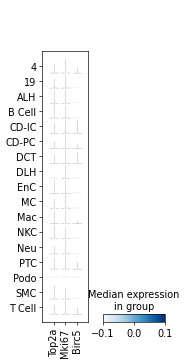

In [67]:
# 似乎不再能捕获到"DC"
sc.pl.stacked_violin(scRNA,['Top2a','Mki67','Birc5'],groupby='Celltype')

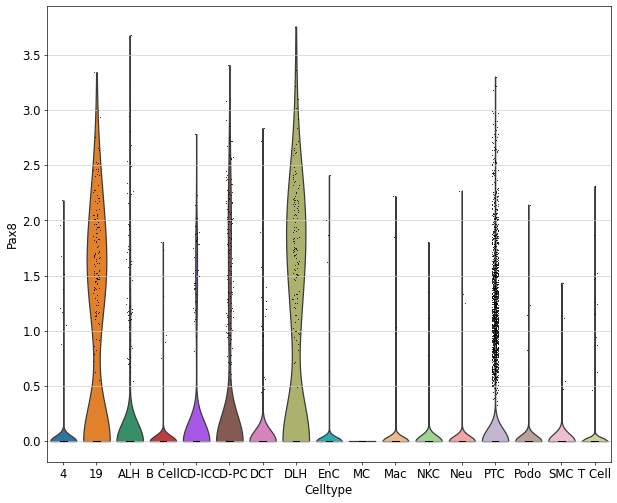

In [86]:
# parietal epithelial cells的marker
sc.pl.violin(scRNA,['Pax8'],groupby='Celltype')# 19考虑为PEC

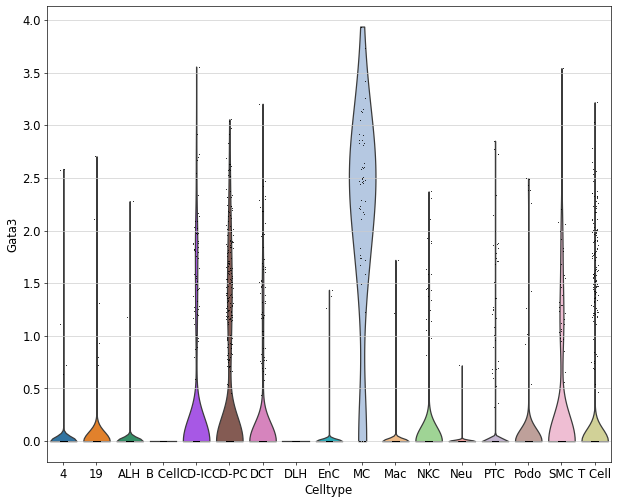

In [71]:
# MC 的marker
sc.pl.violin(scRNA,['Gata3'],groupby='Celltype')

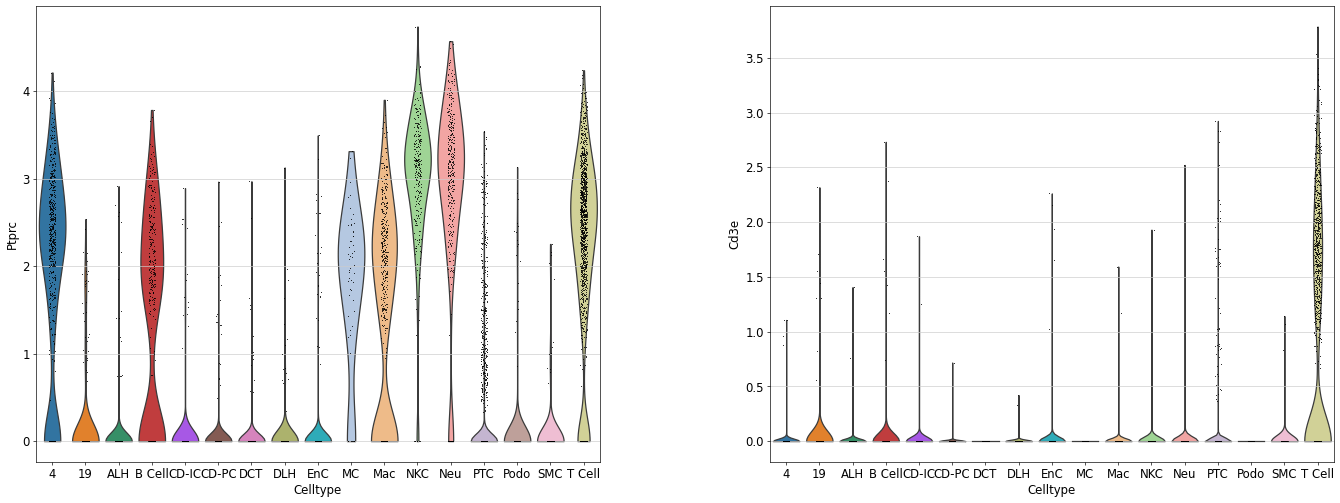

In [73]:
sc.pl.violin(scRNA,['Ptprc','Cd3e'],groupby='Celltype')

In [74]:
print(scRNA.obs['Celltype'].unique().tolist())# 目前还有4、19未注释

['EnC', 'Mac', 'Podo', 'T Cell', '19', 'PTC', 'CD-IC', 'CD-PC', 'ALH', 'SMC', 'DCT', 'DLH', '4', 'Neu', 'B Cell', 'MC', 'NKC']


In [ ]:
#### 第二轮注释

ranking genes
    finished (0:00:24)


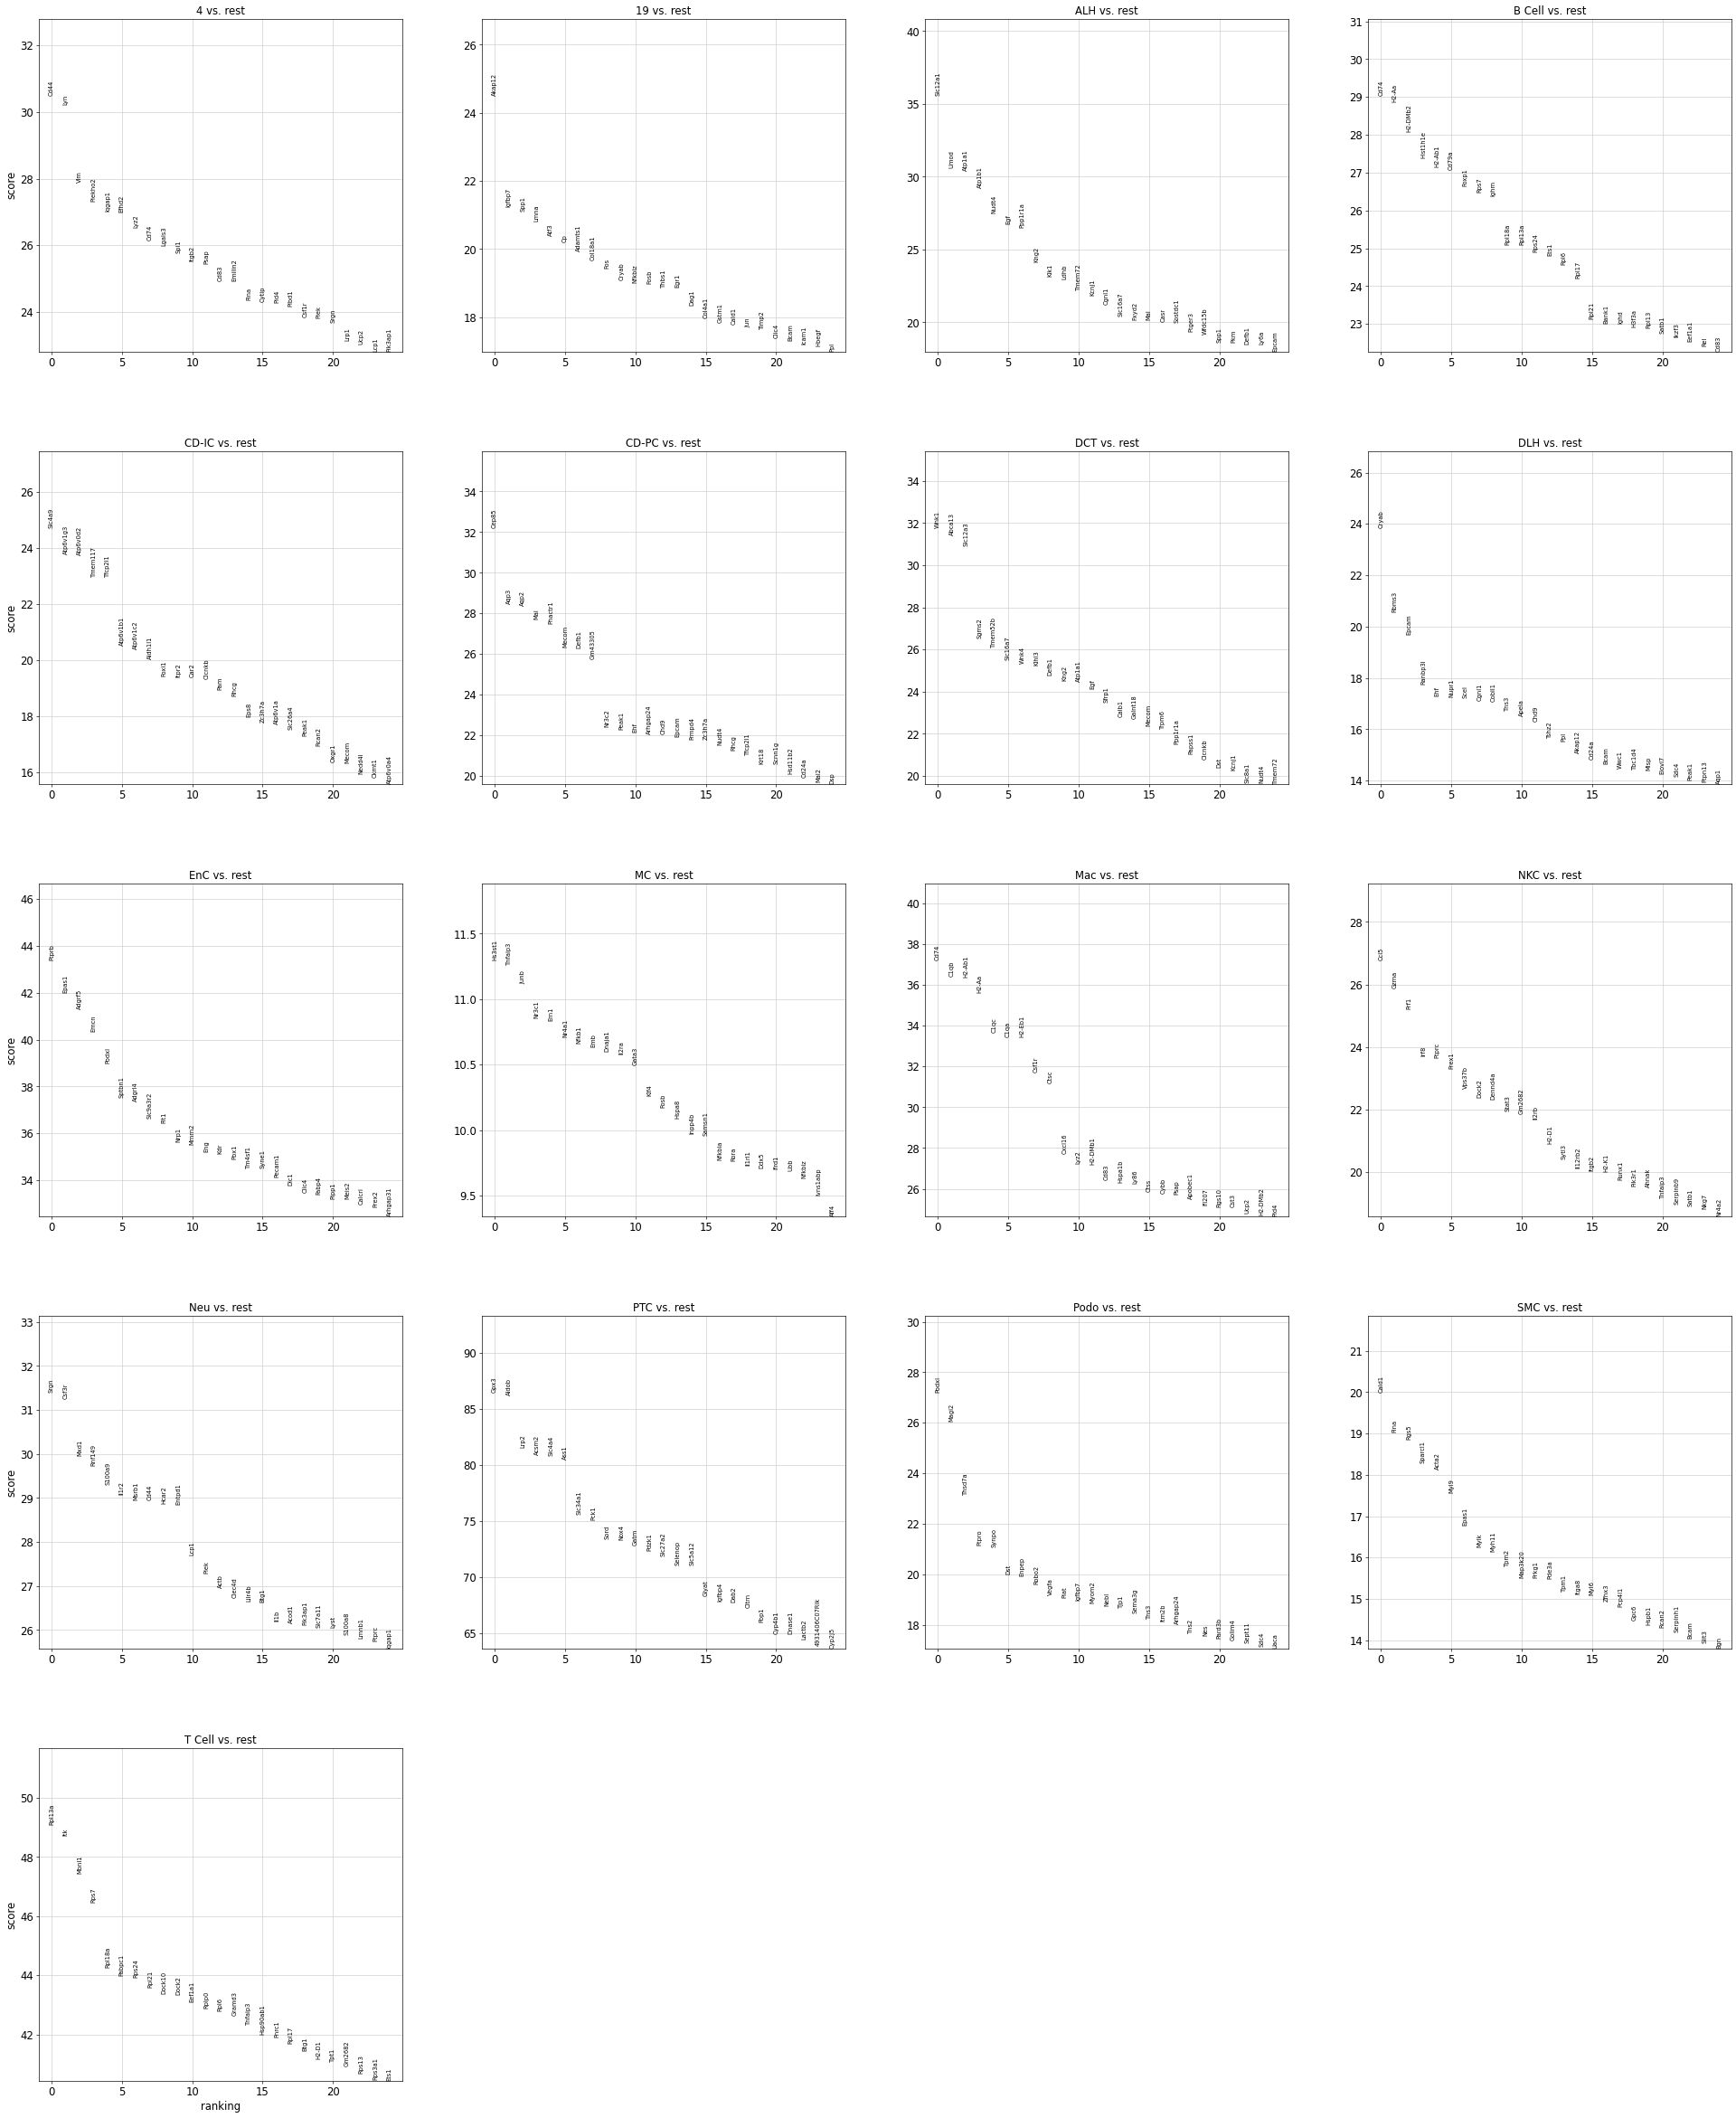

4_names   4_scores        4_pvals    4_pvals_adj  4_logfoldchanges  \
0     Cd44  30.491913  3.335679e-204  6.751414e-200          4.318927   
1      Lyn  30.225706  1.088463e-200  1.101525e-196          4.042638   
2      Vim  27.888756  3.652418e-171  2.464165e-167          4.034722   
3  Plekho2  27.315544  2.772839e-164  1.403056e-160          4.009009   
4   Iqgap1  27.025105  7.494178e-161  3.033643e-157          2.865006   

  19_names  19_scores       19_pvals   19_pvals_adj  19_logfoldchanges  ...  \
0   Akap12  24.505316  1.296457e-132  2.624029e-128           7.289214  ...   
1   Igfbp7  21.245588  3.621419e-100   3.664876e-96           3.544162  ...   
2     Spp1  21.098593   8.193829e-99   5.528103e-95           4.099895  ...   
3     Lmna  20.808352   3.636395e-96   1.840016e-92           4.346510  ...   
4     Atf3  20.389587   2.068817e-92   8.374572e-89           4.482027  ...   

  SMC_names  SMC_scores     SMC_pvals  SMC_pvals_adj  SMC_logfoldchanges  \
0     Cald1   19.991413  6.541611e-89   1.324022e-84            7.303924   
1      Flna   19.019867  1.167815e-80   1.181829e-76            5.639073   
2      Rgs5   18.847862  3.059604e-79   2.064213e-75            9.318172   
3   Sparcl1   18.280512  1.183102e-74   5.986495e-71            7.456528   
4     Acta2   18.130859  1.818958e-73   7.363141e-70            8.482709   

  T Cell_names  T Cell_scores  T Cell_pvals  T Cell_pvals_adj  \
0       Rpl13a      49.086189           0.0               0.0   
1          Itk      48.735004           0.0               0.0   
2        Mbnl1      47.434322           0.0               0.0   
3         Rps7      46.452114           0.0               0.0   
4       Rpl18a      44.240818           0.0               0.0   

   T Cell_logfoldchanges  
0               3.247070  
1               6.369479  
2               3.250922  
3               2.945462  
4               2.879138  

[5 rows x 85 columns]

In [75]:
sc.tl.rank_genes_groups(scRNA, 'Celltype', method='wilcoxon')
sc.pl.rank_genes_groups(scRNA, n_genes=25, sharey=False)

# 查看这些marker在所属cluster中得到的分值：
result_round2 = scRNA.uns['rank_genes_groups']
groups = result_round2['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result_round2[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

# 整理为pd.DataFrame
result_df_round2 = pd.DataFrame(
    {group + '_' + key: result_round2[key][group]
    for group in groups for key in [ 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']})

# 将 DataFrame 写入 CSV 文件
result_df_round2.to_csv('./output/01.procession/marker.rank_round2.csv', index=True)  # index=False 表示不保存行索引

result_df_round2.head()

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Celltype']`


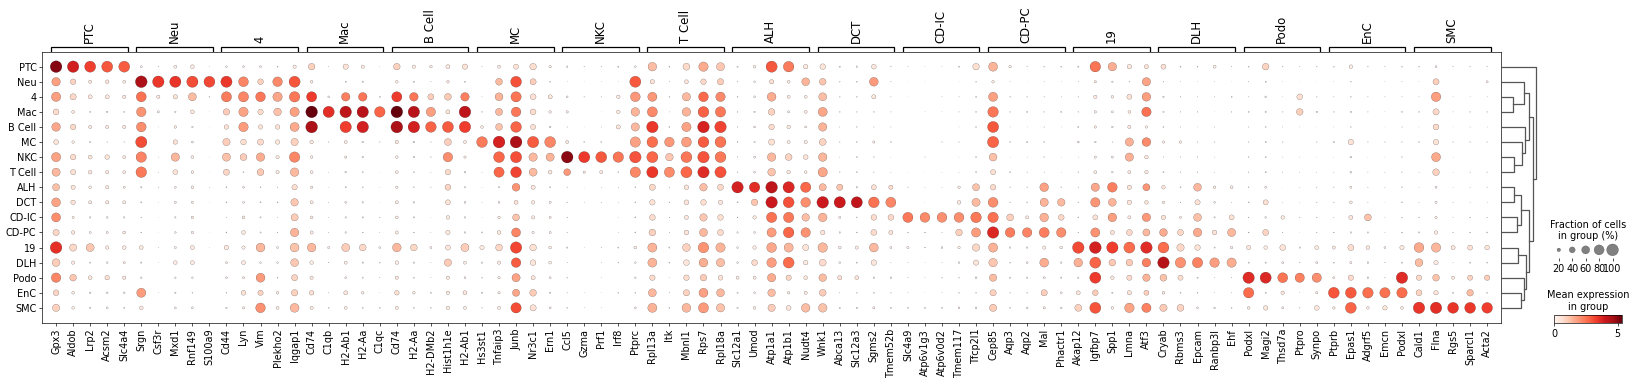

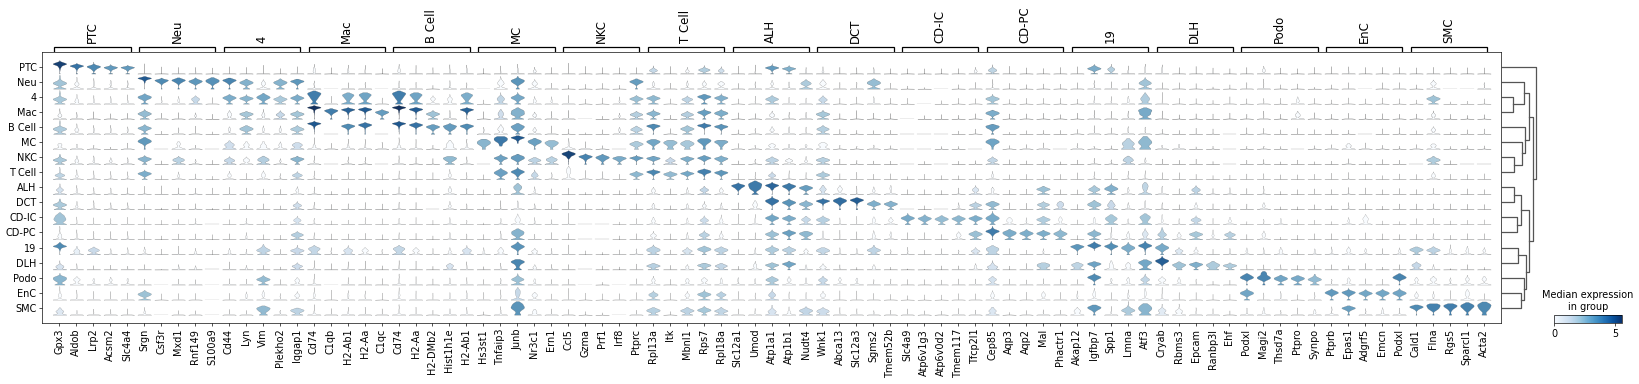

In [77]:
# 画出指定基因在所有cluster中的表达情况：
sc.pl.rank_genes_groups_dotplot(scRNA, n_genes=5)

# 画出指定基因在所有cluster中的表达情况：
sc.pl.rank_genes_groups_stacked_violin(scRNA, n_genes=5,save='round2_marker_dotplot_.pdf')

categories: 4, 19, ALH, etc.
var_group_labels: 4, 19


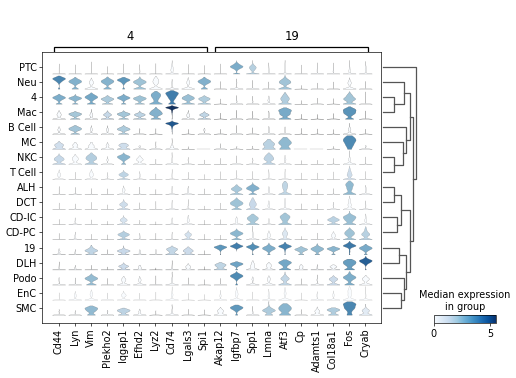

In [79]:
sc.pl.rank_genes_groups_stacked_violin(scRNA, n_genes=10,groups=['4','19'])

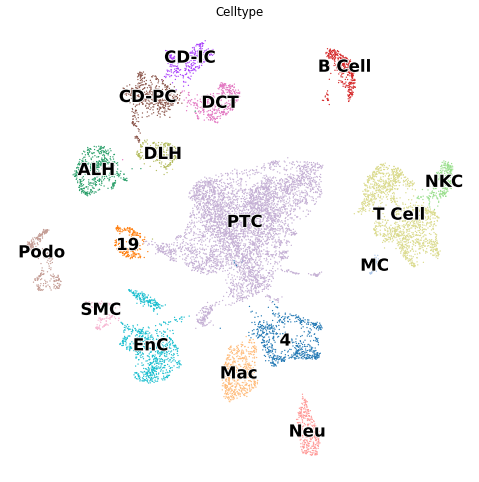

In [81]:
sc.pl.umap(scRNA,color='Celltype', legend_loc='on data', 
           legend_fontsize=20, legend_fontoutline=2)

In [88]:
#### 确定细胞类群
# 4为Mac，19为PEC

# 重命名一下试试
# 重命名各个cluster：
cluster_rename_dict = {
    '4':'Mac',  
    '19':'PEC'
}

# 创建新列 'Cell Type'，并初始化为 'Celltype' 列的值
scRNA.obs['Cell Type'] = scRNA.obs['Celltype']

# 使用字典映射仅替换修改的值
scRNA.obs['Cell Type'].replace(cluster_rename_dict, inplace=True)

# 查看新的 'Cell Type' 列
print(scRNA.obs['Cell Type'].unique().tolist())

['EnC', 'Mac', 'Podo', 'T Cell', 'PEC', 'PTC', 'CD-IC', 'CD-PC', 'ALH', 'SMC', 'DCT', 'DLH', 'Neu', 'B Cell', 'MC', 'NKC']


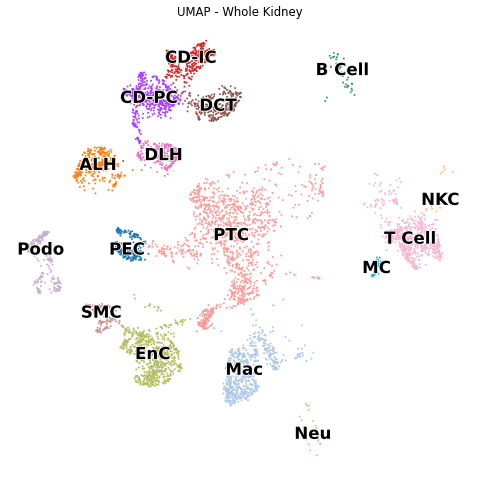

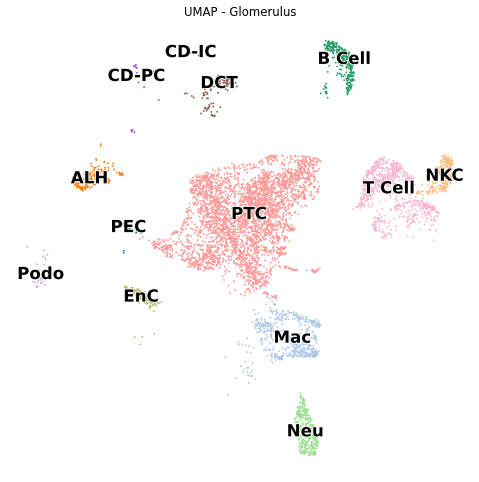

In [95]:
# 获取唯一的 'Tissue' 值
tissue_values = scRNA.obs['Tissue'].unique()

# 遍历每个 'Tissue' 值，拆分数据并绘制 UMAP 图
for tissue in tissue_values:
    tissue_adata = scRNA[scRNA.obs['Tissue'] == tissue, :]
    sc.pl.umap(tissue_adata, color='Cell Type', legend_fontsize=20, legend_fontoutline=2, legend_loc='on data', title=f'UMAP - {tissue}')

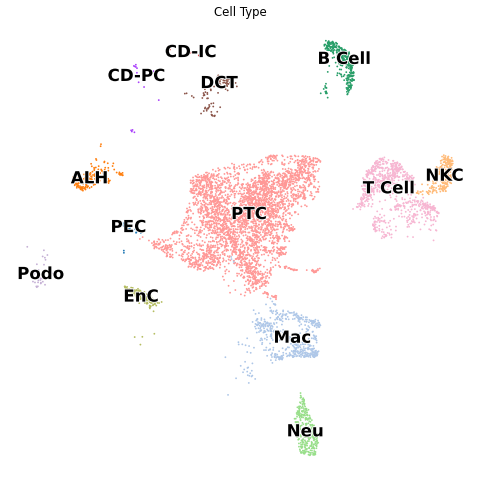

In [100]:
sc.pl.umap(tissue_adata, color='Cell Type', legend_fontsize=20, legend_fontoutline=2, legend_loc='on data')

In [136]:
scRNA.obs['Cell Type'].unique().tolist()

['EnC',
 'Mac',
 'Podo',
 'T Cell',
 'PEC',
 'PTC',
 'CD-IC',
 'CD-PC',
 'ALH',
 'SMC',
 'DCT',
 'DLH',
 'Neu',
 'B Cell',
 'MC',
 'NKC']

In [137]:
# 设置一下Cell Type的顺序：
scRNA.obs['Cell Type'] = pd.Categorical(scRNA.obs['Cell Type'], 
                                        categories=['PTC', 'DLH','ALH','DCT','CD-PC','CD-IC',
                                                    'EnC','PEC','Podo','SMC','MC',
                                                    'T Cell','Mac','B Cell','Neu','NKC'], 
                                        ordered=True)

# 查看新的 'Strategy' 列
print(scRNA.obs['Cell Type'].unique())

['EnC', 'Mac', 'Podo', 'T Cell', 'PEC', ..., 'DLH', 'Neu', 'B Cell', 'MC', 'NKC']
Length: 16
Categories (16, object): ['PTC' < 'DLH' < 'ALH' < 'DCT' ... 'Mac' < 'B Cell' < 'Neu' < 'NKC']


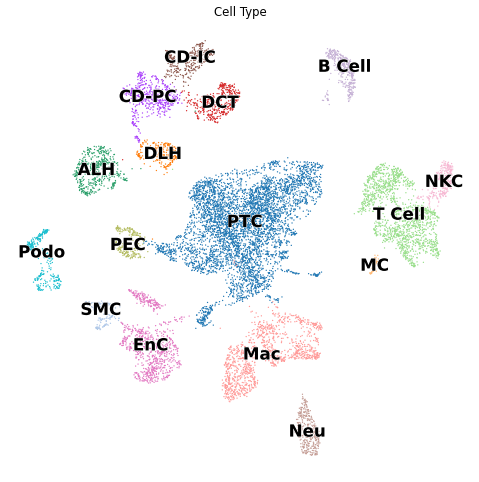

In [169]:
sc.pl.umap(scRNA, color='Cell Type', legend_fontsize=20, legend_fontoutline=1, 
           legend_loc='on data',save='_renamed.umap.pdf'  )

#### 发现分组出现问题，需要修改

In [129]:
scRNA.obs['Strategy'] = scRNA.obs['Tissue']
cluster_rename_dict = {
    'Glomerulus':'WK',  
    'Whole Kidney':'GE'
}

# 使用字典映射仅替换修改的值
scRNA.obs['Strategy'].replace(cluster_rename_dict, inplace=True)
scRNA.obs['Strategy'] = pd.Categorical(scRNA.obs['Strategy'], categories=['WK', 'GE'], ordered=True)

# 查看新的 'Strategy' 列
print(scRNA.obs['Strategy'].unique())

['GE', 'WK']
Categories (2, object): ['WK' < 'GE']


Cell Type count per Strategy:
Cell Type   PTC  DLH  ALH  DCT  CD-PC  CD-IC  EnC  PEC  Podo  SMC  MC  T Cell  \
Strategy                                                                        
WK         3660    0  154  112     16      4  153   30    40    0   0     784   
GE         1232  219  325  271    496    309  693  192   257  148  55     616   

Cell Type  Mac  B Cell  Neu  NKC  
Strategy                          
WK         533     341  338  246  
GE         645      46   23   22  

Cell Type percentage per Strategy:
Cell Type        PTC       DLH       ALH       DCT     CD-PC     CD-IC  \
Strategy                                                                 
WK         57.089378  0.000000  2.402121  1.746997  0.249571  0.062393   
GE         22.202199  3.946657  5.856911  4.883763  8.938547  5.568571   

Cell Type        EnC       PEC      Podo       SMC       MC     T Cell  \
Strategy                                                                 
WK          2.386523  0.

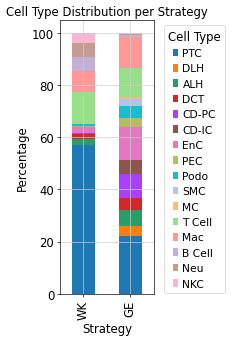

In [138]:
### 统计比例 ###

# 创建一个包含 'Cell Type' 和 'Tissue' 列的 Pandas DataFrame
cell_num = pd.DataFrame({'Cell Type': scRNA.obs['Cell Type'], 'Strategy': scRNA.obs['Strategy']})

# 统计每个 Tissue 中的 Cell Type 数量
count_per_tissue = cell_num.groupby(['Strategy', 'Cell Type']).size().unstack(fill_value=0)

# 计算每个 Tissue 中每个 Cell Type 的比例
percentage_per_tissue = count_per_tissue.div(count_per_tissue.sum(axis=1), axis=0) * 100

# 打印统计结果
print("Cell Type count per Strategy:")
print(count_per_tissue)
print("\nCell Type percentage per Strategy:")
print(percentage_per_tissue)

# 绘制堆叠条形图

percentage_per_tissue.plot(kind='bar', stacked=True, figsize=(2, 6), width = 0.5)
plt.title('Cell Type Distribution per Strategy')
plt.xlabel('Strategy')
plt.ylabel('Percentage')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# 保存pdf
plt.savefig('output/02.cell_ann/cell_prop_v2.pdf', bbox_inches='tight') 
plt.show()

In [139]:
cell_counts

Strategy     WK    GE
Cell Type            
PEC          30   192
ALH         154   325
B Cell      341    46
CD-IC         4   309
CD-PC        16   496
DCT         112   271
DLH           0   219
EnC         153   693
MC            0    55
Mac         533   645
NKC         246    22
Neu         338    23
PTC        3660  1232
Podo         40   257
SMC           0   148
T Cell      784   616

<Figure size 360x240 with 0 Axes>

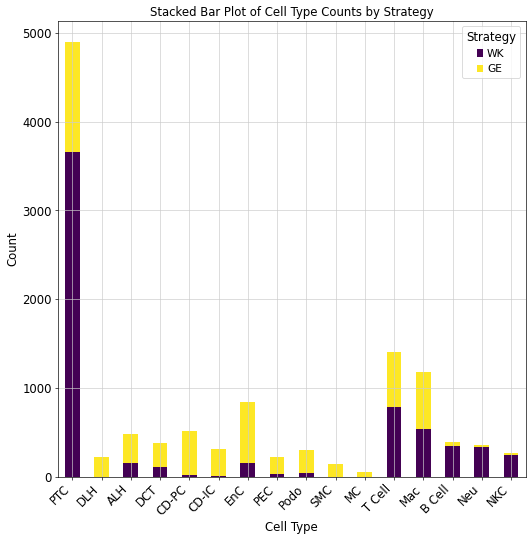

In [140]:
# 计算每个细胞类型和策略的数量
cell_counts = cell_num.groupby(['Cell Type', 'Strategy']).size().unstack(fill_value=0)

# 创建堆叠条形图
plt.figure(figsize=(12, 8))
cell_counts.plot(kind='bar', stacked=True, colormap='viridis')

# 设置图形标题和标签
plt.title('Stacked Bar Plot of Cell Type Counts by Strategy')
plt.xlabel('Cell Type')
plt.ylabel('Count')

# 旋转 x 轴标签以更好地显示
plt.xticks(rotation=45, ha='right')

# 显示图例
plt.legend(title='Strategy')

plt.savefig('output/02.cell_ann/cell_num_v2.pdf', bbox_inches='tight') 
# 显示图形
plt.show()

In [141]:
if not os.path.exists('./output/02.cell_ann'):
    os.makedirs('./output/02.cell_ann')
count_per_tissue.to_csv('./output/02.cell_ann/cell_count_per_tissue.csv')
percentage_per_tissue.to_csv('./output/02.cell_ann/cell_percent_per_tissue.csv')

#### 展示marker

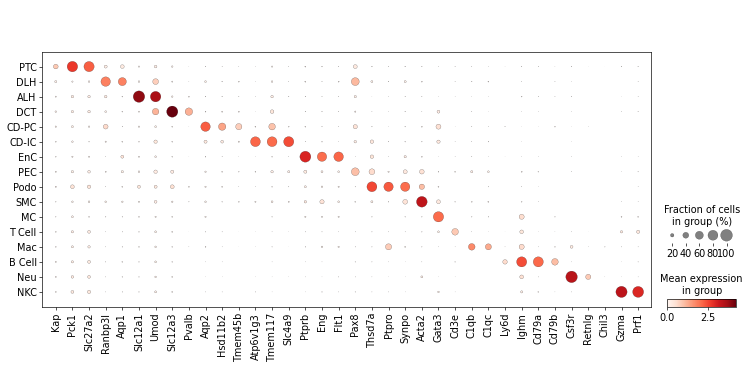

In [167]:
sc.pl.dotplot(scRNA,
              ['Kap','Pck1','Slc27a2', # PTC
               'Ranbp3l','Aqp1', # DLH
            'Slc12a1','Umod', # ALH
               'Slc12a3','Pvalb',# DCT
               'Aqp2','Hsd11b2','Tmem45b' ,# CD-PC
               'Atp6v1g3','Tmem117','Slc4a9', # CD-IC
               'Ptprb','Eng','Flt1',# EnC
               'Pax8',# PEC
               'Thsd7a','Ptpro','Synpo',# Podo
              'Acta2' ,# SMC
               'Gata3', # MC
               'Cd3e', # T Cell
               'C1qb','C1qc', # Mac
               'Ly6d','Ighm','Cd79a','Cd79b', # B Cell
               'Csf3r','Retnlg','Chil3' , # Neu
               'Gzma','Prf1' # NKC
              ],groupby='Cell Type',save='renamed_v2_dotplot.pdf')

In [ ]:
# 后续分析等待空转数据出来后继续进行

In [170]:
# 保存scRNA对象：
scRNA.write('./output/imagedata/scRNA_v4.h5ad', compression="gzip")

In [172]:
import dill

# 保存所有变量
# 保存整个会话状态
dill.dump_session('output/imagedata/session_state.pkl')

In [ ]:
# 在需要的时候加载整个会话状态
dill.load_session('session_state.pkl')